### Gene expression vs 3D changes during Legionella infection
**cmdoret**

In this report I analyse the relationship between gene expression and spatial changes in _A. castellanii_ upon _L. pneumophila_ infection. I use differential expression results from [Li et al. 2020](https://www.frontiersin.org/articles/10.3389/fcimb.2020.00428/full#h4), and have lifted over the neff v1 annotations they used to the C3 genome.
> Note: I allowed multi-mapping, which means a single C3 gene can match multiple Neff gene and vice versa.

In [1]:
import os
os.chdir('/home/cmatthey/Repos/Acastellanii_legionella_infection/')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cooler

diff_expr = pd.read_csv('data/output/diff_expr/de_genes.tsv', sep='\t')
liftover = pd.read_csv('data/tmp/liftoff/neff_c3_liftover.gff', sep='\t', header=None, usecols=[0, 2, 3, 4, 8])
liftover.columns = ['chrom', 'type', 'start', 'end', 'attr']
liftover = liftover.loc[liftover['type'] == 'gene', :]
liftover['accession'] = liftover['attr'].str.replace(r'ID=gene:([^;]*);.*', r'\1')
liftover['desc'] = liftover['attr'].str.replace(r'.*description=([^;]*);.*', r'\1')

In [3]:
liftover

,chrom,type,start,end,attr,accession,desc
0,scaffold_1,gene,517,5457,ID=gene:ACA1_272090;biotype=protein_coding;des...,ACA1_272090,Ras subfamily protein
40,scaffold_1,gene,6183,9815,ID=gene:ACA1_272100;biotype=protein_coding;des...,ACA1_272100,hypothetical protein
50,scaffold_1,gene,10749,11427,ID=gene:ACA1_272220;biotype=protein_coding;des...,ACA1_272220,hypothetical protein
60,scaffold_1,gene,30871,33218,ID=gene:ACA1_272240;biotype=protein_coding;des...,ACA1_272240,hypothetical protein
82,scaffold_1,gene,33329,33978,ID=gene:ACA1_272250;biotype=protein_coding;des...,ACA1_272250,hemerythrin hhe cation binding subfamily protein
...,...,...,...,...,...,...,...
213267,scaffold_90,gene,3593,4330,ID=gene:ACA1_374170;biotype=protein_coding;des...,ACA1_374170,hypothetical protein
213275,scaffold_90,gene,9190,9784,ID=gene:ACA1_374160;biotype=protein_coding;des...,ACA1_374160,hypothetical protein
213283,scaffold_93,gene,5734,6486,ID=gene:ACA1_045660;biotype=protein_coding;des...,ACA1_045660,hypothetical protein
213289,scaffold_93,gene,6787,6829,ID=gene:ACA1_263500;biotype=protein_coding;des...,ACA1_263500,polyprotein


In [4]:
print(f"{100* diff_expr.c3.isnull().sum() / diff_expr.shape[0]:.2f}% lifted-over genes had no match in my de-novo annotation pipeline")

20.75% lifted-over genes had no match in my de-novo annotation pipeline


<IPython.core.display.Javascript object>


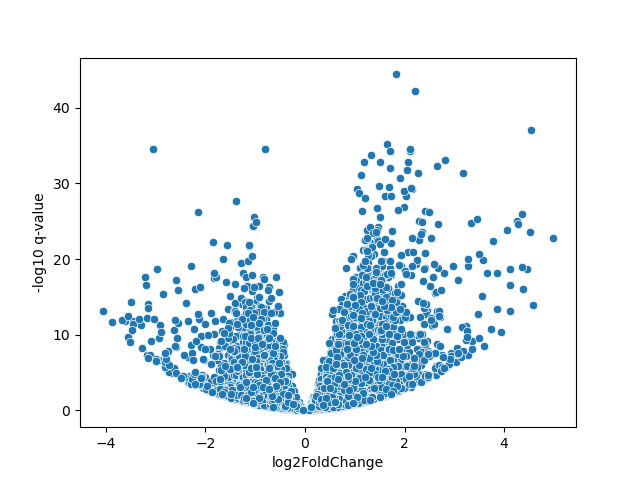

Text(0, 0.5, '-log10 q-value')

In [5]:
%matplotlib notebook

sns.scatterplot(x=diff_expr.log2FoldChange, y=-np.log10(diff_expr.padj))
plt.ylabel("-log10 q-value")

Let's subset genes which are highly differentially expressed:


In [6]:
PADJ_THRESH = 0.05
L2FC_THRESH = 2

In [7]:
sig_expr = diff_expr.loc[(diff_expr.padj < PADJ_THRESH) & (abs(diff_expr.log2FoldChange) > L2FC_THRESH), :].sort_values('padj')

In [8]:
sig_expr = sig_expr.merge(liftover, on='accession', how='left').sort_values('padj')
sig_expr = sig_expr.dropna()
sig_expr.start = sig_expr.start.astype(int)
sig_expr.end = sig_expr.end.astype(int)
sig_expr = sig_expr.drop_duplicates(subset=['accession']).reset_index(drop=True)

In [9]:
print(
    f'We subsetted {sig_expr.shape[0]} genes ({100*sig_expr.shape[0] / diff_expr.shape[0]:.2f}%) ',
    f'with more than {L2FC_THRESH} log2 fold change and adjusted p-value below {PADJ_THRESH}.')

We subsetted 241 genes (1.50%)  with more than 2 log2 fold change and adjusted p-value below 0.05.


Li et al reported that sirtuin-related genes were upregulated during infection, notably ACA1_153540. Let's have a look at these.

In [10]:
sig_expr.loc[sig_expr.accession ==  'ACA1_153540', :]


,accession,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,c3,chrom,type,start,end,attr,desc
15,ACA1_153540,1458.066017,4.365291,0.388818,11.227093,3.000000e-29,1.060000e-26,FUN_007560,scaffold_24,gene,875568,878213,ID=gene:ACA1_153540;biotype=protein_coding;des...,"transcriptional regulator, Sir2 family protein"


It is indeed in our top differentially expressed gene list. 

For the next, preliminary analyses I will work with a subset of genes to avoid blowing up memory.

In [174]:
sub_genes = liftover.sample(1000)

### Computing gene-based statistics from Hi-C data

So if we want to associate expression data to Hi-C data, we need to tie contact values to individual genes.
What I will do here is retrieve contact values between all pairs of genes before and after infection (2 replicates each). For every gene pair, I will then compute a contact change score (ratio, t-test, ...).
This will give us an interaction change network of NxN genes. I will then see how interaction change relate to co-expression using the RNAseq.

> Note: All this will be done on the normalized and detrended matrix to correct for accessibility and genomic distance.

In [168]:
hic_samples = pd.read_csv('samples.tsv', sep='\t', comment='#')
clr_ctl = cooler.Cooler('data/output/cool/uninfected_merged_subsampled.cool')
clr_inf = cooler.Cooler('data/output/cool/infected_merged_subsampled.cool')

In [169]:
import itertools as it
import subprocess as sp
import tempfile
import shlex

def run_command(cmd: str):
    p = sp.Popen(shlex.split(cmd), bufsize=1, universal_newlines=True)
    return p.poll()

def get_contact_gene_pairs(cool_path: str, genes: pd.DataFrame, winsize=7) -> pd.DataFrame:
    """
    Compute contacts between all gene pairs.
    genes must have columns: chrom start end accession
    """
    # Generate all pairwise gene combinations and save as bed2d
    tmp_bed = tempfile.NamedTemporaryFile(delete=False)
    combs = pd.DataFrame((it.combinations(genes.accession, 2)))
    combs.columns = ['g1', 'g2']
    combs = combs.merge(genes.loc[:, ['chrom', 'start', 'end', 'accession']], right_on='accession', left_on='g1')
    combs = combs.merge(genes.loc[:, ['chrom', 'start', 'end', 'accession']], right_on='accession', left_on='g2')
    combs = combs.loc[:, ['chrom_x', 'start_x', 'end_x', 'chrom_y', 'start_y', 'end_y']]
    combs.to_csv(tmp_bed.name, sep='\t', header=False, index=False)
    
    # Run chromosight to extract windows of the Hi-C matrix at each inter-gene coordinate
    with tempfile.TemporaryDirectory() as chromo_dir:
        cmd = f'chromosight quantify --win-fmt=npy -t12 -z100 -I -W{winsize} {tmp_bed.name} {cool_path} {chromo_dir}/curr'
        !{cmd} # jupyter syntax. In regular python script use run_command function instead
    
        # Retrieve windows. We don't actually care about scores
        wins = np.load(chromo_dir + "/curr.npy")
        coords = pd.read_csv(chromo_dir + "/curr.tsv", sep='\t', usecols=range(6))
    
    # Annotate chromosight output with gene accessions
    coords = coords.merge(
        genes.loc[:, ['chrom', 'start', 'end', 'accession']].add_suffix('1'),
        on=['chrom1', 'start1', 'end1'],
        how='left',
    )
    coords = coords.merge(
        genes.loc[:, ['chrom', 'start', 'end', 'accession']].add_suffix('2'),
        on=['chrom2', 'start2', 'end2'],
        how='left',
    )
    # For each gene pair, add the mean contact value in the window as a column
    coords['mean_contacts'] = np.nansum(np.nansum(wins, axis=1), axis=1)/(wins.shape[0] * wins.shape[1])
    
    return coords

In [176]:
p_hic = get_contact_gene_pairs('data/output/cool/uninfected_merged_subsampled.cool', sub_genes)
p_hic = p_hic.rename(columns={'mean_contacts': 'ctl_contacts'})
p_hic['inf_contacts'] = get_contact_gene_pairs('data/output/cool/infected_merged_subsampled.cool', sub_genes)['mean_contacts']


max_perc_undetected set to 50.0 based on config file.
Matrix already balanced, reusing weights
Found 22005 / 22111 detectable bins
Preprocessing sub-matrices...
 [====================] 100.0% scaffold_36-scaffold_36[K
Sub matrices extracted
 [--------------------] 0.0% Kernel: 0
 [====================] 99.8% scaffold_36-scaffold_36Saving pileup plots in /tmp/tmp1u7q9k7g/curr.pdf
max_perc_undetected set to 50.0 based on config file.
Matrix already balanced, reusing weights
Found 22020 / 22111 detectable bins
Preprocessing sub-matrices...
 [====================] 100.0% scaffold_36-scaffold_36[K
Sub matrices extracted
 [--------------------] 0.0% Kernel: 0
 [====================] 99.8% scaffold_36-scaffold_36Saving pileup plots in /tmp/tmpc_xt6y4e/curr.pdf


<IPython.core.display.Javascript object>


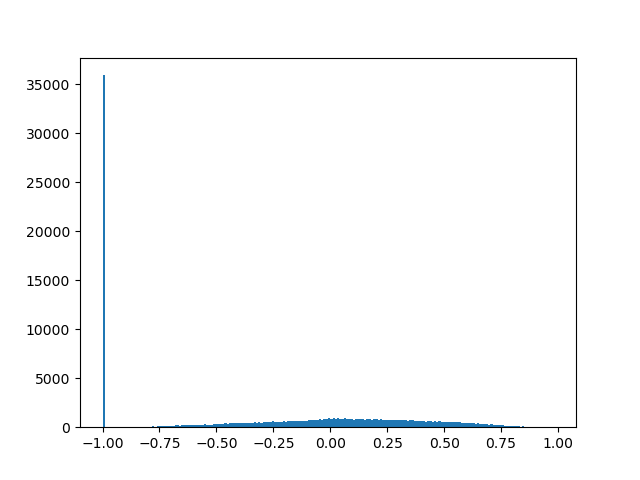

In [178]:
%matplotlib notebook
gene_space = p_hic.loc[(p_hic.ctl_contacts + p_hic.ctl_contacts) > 0, :]
f = plt.hist((gene_space.inf_contacts - gene_space.ctl_contacts) / (gene_space.inf_contacts + gene_space.ctl_contacts), 200)

In [179]:
gene_space

,chrom1,start1,end1,chrom2,start2,end2,accession1,accession2,ctl_contacts,inf_contacts
0,scaffold_15,1008470,1009701,scaffold_27,998181,999646,ACA1_149010,ACA1_325590,2.240484e-07,5.015518e-07
3,scaffold_15,1008470,1009701,scaffold_20,975163,975932,ACA1_149010,ACA1_076070,8.613807e-07,0.000000e+00
5,scaffold_12,557731,564778,scaffold_20,975163,975932,ACA1_086070,ACA1_076070,7.463425e-07,6.446116e-07
10,scaffold_15,1008470,1009701,scaffold_21,1068868,1070487,ACA1_149010,ACA1_097750,1.864109e-07,3.881569e-07
13,scaffold_20,975163,975932,scaffold_21,1068868,1070487,ACA1_076070,ACA1_097750,4.668396e-07,9.114914e-07
...,...,...,...,...,...,...,...,...,...,...
499483,scaffold_24,102052,103153,scaffold_34,128416,129672,ACA1_031590,ACA1_184130,3.079616e-07,8.299108e-07
499485,scaffold_2,1469117,1472896,scaffold_34,128416,129672,ACA1_061090,ACA1_184130,6.292280e-07,0.000000e+00
499489,scaffold_14,1159909,1162898,scaffold_34,128416,129672,ACA1_383140,ACA1_184130,9.919216e-07,0.000000e+00
499491,scaffold_14,1349723,1352093,scaffold_34,128416,129672,ACA1_101420,ACA1_184130,6.770019e-07,4.545938e-07


In [180]:
nnz_gene_pairs = gene_space.shape[0]
nnz_inter_pairs = gene_space.loc[gene_space.chrom1 != gene_space.chrom2, :].shape[0]
print(f'There are {nnz_gene_pairs} gene pairs with nonzero contacts (out of {p_hic.shape[0]}).'
      f' {nnz_inter_pairs} of these are interchromosomal'
)

There are 118429 gene pairs with nonzero contacts (out of 499500). 102323 of these are interchromosomal


In [284]:
liftover.loc[liftover.accession == 'ACA1_000580']

,chrom,type,start,end,attr,accession,desc
25936,scaffold_11,gene,1280168,1282424,ID=gene:ACA1_000580;biotype=protein_coding;des...,ACA1_000580,hypothetical protein


In [281]:
hic_mat

ctl_contacts                                            \
accession2   ACA1_000580   ACA1_001260   ACA1_006070   ACA1_006110   
accession1                                                           
ACA1_000580          0.0  9.203255e-07  0.000000e+00  0.000000e+00   
ACA1_001260          0.0  0.000000e+00  0.000000e+00  6.308790e-07   
ACA1_006070          0.0  0.000000e+00  0.000000e+00  0.000000e+00   
ACA1_006110          0.0  0.000000e+00  1.164417e-05  0.000000e+00   
ACA1_006240          0.0  0.000000e+00  1.511191e-05  1.109647e-05   
...                  ...           ...           ...           ...   
ACA1_398920          0.0  8.889291e-06  0.000000e+00  3.017965e-07   
ACA1_399220          0.0  6.574266e-06  0.000000e+00  0.000000e+00   
ACA1_400390          0.0  0.000000e+00  4.843120e-07  7.735585e-07   
ACA1_400910          0.0  0.000000e+00  5.977343e-07  0.000000e+00   
ACA1_401230          0.0  0.000000e+00  5.977343e-07  5.633340e-07   

                                                                               \
accession2    ACA1_006240 ACA1_006680   ACA1_007510 ACA1_007750   ACA1_010730   
accession1                                                                      
ACA1_000580  0.000000e+00         0.0  0.000000e+00         0.0  0.000000e+00   
ACA1_001260  0.000000e+00         0.0  0.000000e+00         0.0  0.000000e+00   
ACA1_006070  0.000000e+00         0.0  0.000000e+00         0.0  0.000000e+00   
ACA1_006110  0.000000e+00         0.0  0.000000e+00         0.0  0.000000e+00   
ACA1_006240  0.000000e+00         0.0  0.000000e+00         0.0  0.000000e+00   
...                   ...         ...           ...         ...           ...   
ACA1_398920  0.000000e+00         0.0  0.000000e+00         0.0  1.239756e-07   
ACA1_399220  0.000000e+00         0.0  0.000000e+00         0.0  0.000000e+00   
ACA1_400390  9.120108e-07         0.0  2.223525e-07         0.0  7.967021e-07   
ACA1_400910  2.182966e-07         0.0  6.885825e-07         0.0  1.464681e-07   
ACA1_401230  2.182966e-07         0.0  3.538514e-07         0.0  3.413220e-07   

                         ...                                                  \
accession2  ACA1_012020  ... ACA1_396920 ACA1_396950 ACA1_397210 ACA1_397270   
accession1               ...                                                   
ACA1_000580         0.0  ...         0.0         0.0    0.000000    0.000000   
ACA1_001260         0.0  ...         0.0         0.0    0.000000    0.000000   
ACA1_006070         0.0  ...         0.0         0.0    0.000000    0.000000   
ACA1_006110         0.0  ...         0.0         0.0    0.000000    0.000000   
ACA1_006240         0.0  ...         0.0         0.0    0.000000    0.000000   
...                 ...  ...         ...         ...         ...         ...   
ACA1_398920         0.0  ...         0.0         0.0    0.000008    0.000009   
ACA1_399220         0.0  ...         0.0         0.0    0.000005    0.000005   
ACA1_400390         0.0  ...         0.0         0.0    0.000000    0.000000   
ACA1_400910         0.0  ...         0.0         0.0    0.000000    0.000000   
ACA1_401230         0.0  ...         0.0         0.0    0.000000    0.000000   

                                                                             \
accession2  ACA1_398310 ACA1_398920 ACA1_399220   ACA1_400390   ACA1_400910   
accession1                                                                    
ACA1_000580    0.000000    0.000001         0.0  0.000000e+00  0.000000e+00   
ACA1_001260    0.000000    0.000000         0.0  9.797196e-07  1.510377e-06   
ACA1_006070    0.000000    0.000000         0.0  0.000000e+00  0.000000e+00   
ACA1_006110    0.000000    0.000000         0.0  0.000000e+00  0.000000e+00   
ACA1_006240    0.000000    0.000000         0.0  0.000000e+00  0.000000e+00   
...                 ...         ...         ...           ...           ...   
ACA1_398920    0.000013    0.000000         0.0  1.039564e-06  9

<IPython.core.display.Javascript object>


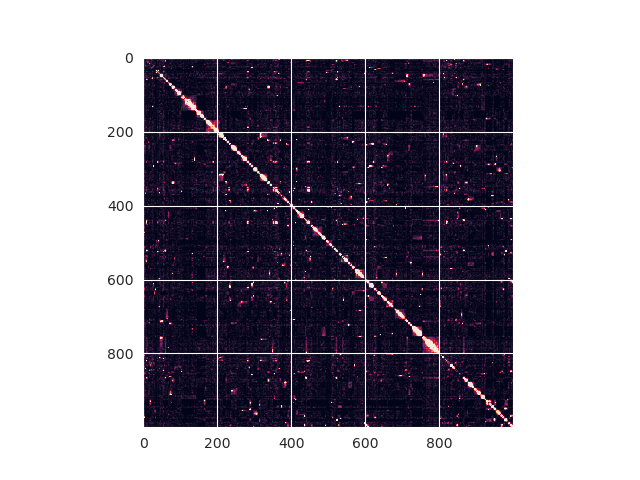

In [287]:
%matplotlib notebook
hic_mat = p_hic.sort_values(['chrom1', 'start1', 'chrom2', 'start2']).loc[:, ['accession1', 'accession2', 'ctl_contacts']].pivot('accession1', 'accession2').fillna(0)
plt.imshow(np.log1p(hic_mat.to_numpy() + hic_mat.to_numpy().T), vmax = np.percentile(hic_mat, 99.5))

#### Co-variation of gene expression and 3D changes over time

I have formatted the data from Li et al to get the expression of each gene at each timepoint.
First, let's visualize the co-expression of all genes across the 4 time points.


In [181]:
expr_time = pd.read_csv('data/output/diff_expr/expr_vs_time.tsv', sep='\t')

In [182]:
#expr_time['expr'] = 2**expr_time.log2FoldChange *   expr_time.baseMean
expr_time['expr'] = expr_time['log2FoldChange']

In [183]:
def expr_to_corr(df):
    """Convert time vs expression df to correlation matrix"""
    mat = df.loc[:, ['accession', 'time', 'expr']].pivot('accession', 'time')
    mat.columns = mat.columns.get_level_values(1)
    mat.columns.name = None
    mat = mat.dropna(axis=0)
    corr = mat.transpose().corr().fillna(0)
    
    return corr

corr_mat = expr_to_corr(expr_time)


Here, I cluster genes along the co-expression matrix using hierarchical clustering

In [184]:
import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

<IPython.core.display.Javascript object>


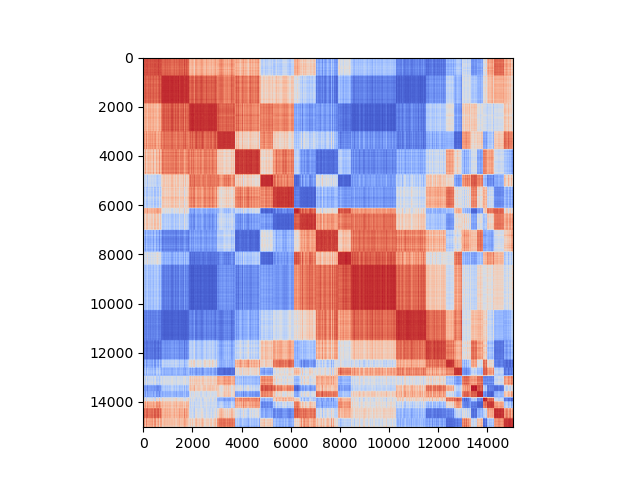

In [49]:
%matplotlib notebook
plt.imshow(cluster_corr(corr_mat), cmap='coolwarm', vmin=-1, vmax=1)

Here, I subset this dataset to include only genes that are significantly differentially expressed at the timepoint of interest. 

In [193]:
#corr_sig = expr_to_corr(expr_time.loc[expr_time.accession.isin(sig_expr.accession)])
corr_sub = expr_to_corr(
    expr_time.loc[
        expr_time.accession.isin(sub_genes.accession), :
    ].reset_index(drop=True)
)
corr_sub.index = corr_sub.index.rename('accession1')
long_corr = corr_sub.stack().reset_index()
long_corr = long_corr.rename(columns={'accession': 'accession2', 0: 'coexpr'})

The co-expression matrix now looks much simpler. Looks like 4 gene clusters.

<IPython.core.display.Javascript object>


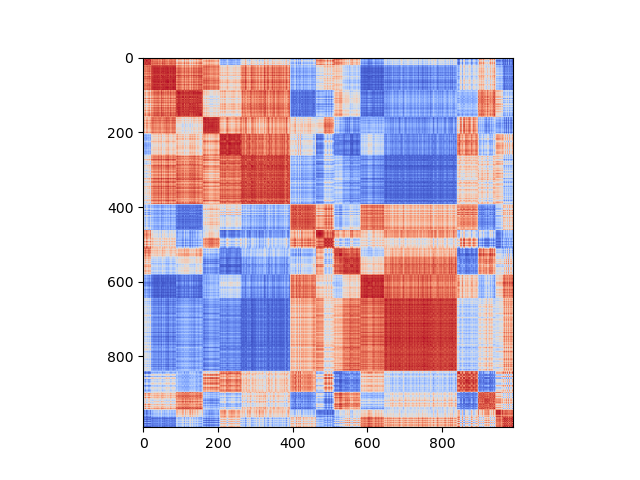

In [186]:
%matplotlib notebook
plt.imshow(cluster_corr(corr_sig), cmap='coolwarm')

Now let's plug in the Hi-C contact changes with co-expression data !

In [203]:
long_corr_upper = long_corr.loc[long_corr.accession1 < long_corr.accession2, :]

In [204]:
hic_rna = p_hic.merge(long_corr_upper, on=['accession1', 'accession2'], how='inner')
hic_rna['contacts_change'] = (hic_rna.inf_contacts - hic_rna.ctl_contacts) / (hic_rna.inf_contacts + hic_rna.ctl_contacts)
#hic_rna = hic_rna.loc[hic_rna.contacts_change > -1, :]

After removing genes with 0 contacts, we see taht the distribution of gene-pairs co-expression follows a bimodal gausian, whereas the contacts change is ~ gaussian around 0 There does not seem to be a global correlation between contact change and co-expression during infection.

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<IPython.core.display.Javascript object>


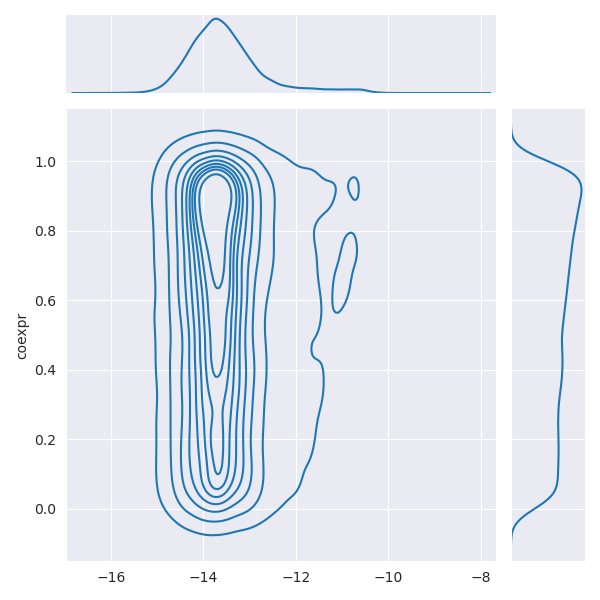

In [265]:
%matplotlib notebook
# Dropping all gene pairs where at least one gene has zero contacts
hr_clean = hic_rna.dropna().loc[
    (hic_rna.ctl_contacts > 0) & (hic_rna.inf_contacts > 0), :
]

sns.jointplot(np.log(hr_clean.inf_contacts+hr_clean.ctl_contacts), hr_clean.coexpr.abs(), kind='kde')

In [267]:
import scipy.stats as ss
ss.pearsonr(np.abs(hr_clean.coexpr), np.log(hr_clean.inf_contacts+hr_clean.ctl_contacts))

(-0.003589695801518637, 0.4843948139569884)

In [191]:
hic_rna

,chrom1,start1,end1,chrom2,start2,end2,accession1,accession2,ctl_contacts,inf_contacts,coexpr,contacts_change
0,NaN,NaN,NaN,NaN,NaN,NaN,ACA1_000580,ACA1_000580,NaN,NaN,1.000000,NaN
1,scaffold_11,1280168.0,1282424.0,scaffold_17,688606.0,691907.0,ACA1_000580,ACA1_001260,9.203255e-07,3.265665e-07,-0.467611,-0.476191
2,NaN,NaN,NaN,NaN,NaN,NaN,ACA1_000580,ACA1_006070,NaN,NaN,0.872316,NaN
3,scaffold_11,1280168.0,1282424.0,scaffold_28,76739.0,77615.0,ACA1_000580,ACA1_006110,0.000000e+00,4.782926e-07,-0.421357,1.000000
4,scaffold_11,1280168.0,1282424.0,scaffold_28,44112.0,44967.0,ACA1_000580,ACA1_006240,0.000000e+00,9.328546e-07,-0.984155,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
980095,NaN,NaN,NaN,NaN,NaN,NaN,ACA1_401230,ACA1_398920,NaN,NaN,0.597085,NaN
980096,NaN,NaN,NaN,NaN,NaN,NaN,ACA1_401230,ACA1_399220,NaN,NaN,-0.763041,NaN
980097,NaN,NaN,NaN,NaN,NaN,NaN,ACA1_401230,ACA1_400390,NaN,NaN,-0.825628,NaN
980098,NaN,NaN,NaN,NaN,NaN,NaN,ACA1_401230,ACA1_400910,NaN,NaN,0.855227,NaN


/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<IPython.core.display.Javascript object>


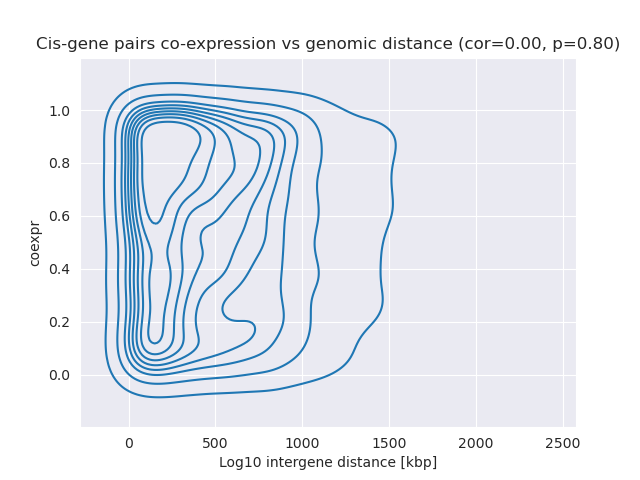

Text(0.5, 0, 'Log10 intergene distance [kbp]')

In [224]:
%matplotlib notebook
cis = hic_rna.loc[hic_rna.chrom1 == hic_rna.chrom2, :]
sns.kdeplot(abs(cis.start2 - cis.start1)/1000, abs(cis.coexpr))
cor = ss.pearsonr(abs(cis.start2 - cis.start1)/1000, abs(cis.coexpr))
plt.title(f'Cis-gene pairs co-expression vs genomic distance (cor={cor[0]:.2f}, p={cor[1]:.2f})')
plt.xlabel("Log10 intergene distance [kbp]")

Are gene on the same chromosome more co-regulated ?

<IPython.core.display.Javascript object>


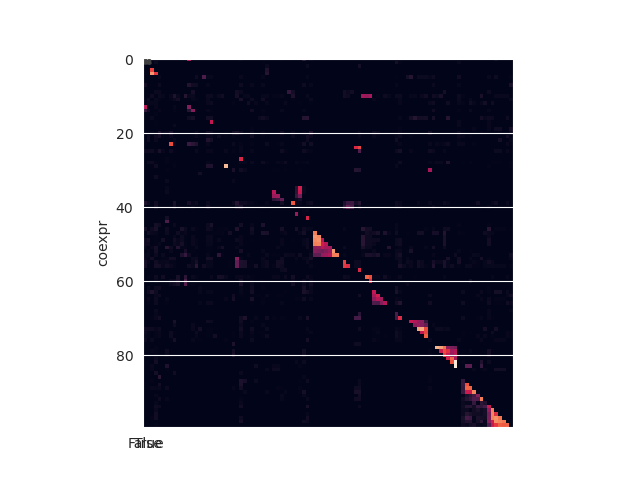

<AxesSubplot:ylabel='coexpr'>

In [229]:
%matplotlib notebook
sns.violinplot(x=hic_rna.chrom1 == hic_rna.chrom2, y=np.abs(hic_rna.coexpr), inner='quart')

Are genes within the same TAD co-regulated during infection ?

#### Unsupervised exploration of gene expression

In [125]:
%matplotlib notebook
from sklearn.decomposition import PCA
import seaborn as sns
pca = PCA()
pcs = pca.fit_transform(expr_mat)
sns.jointplot(pcs[:, 0], pcs[:, 1])

NameError: name 'expr_mat' is not defined

In [57]:
import umap
um = umap.UMAP(n_neighbors=50)

embd = um.fit_transform(expr_mat)

<IPython.core.display.Javascript object>


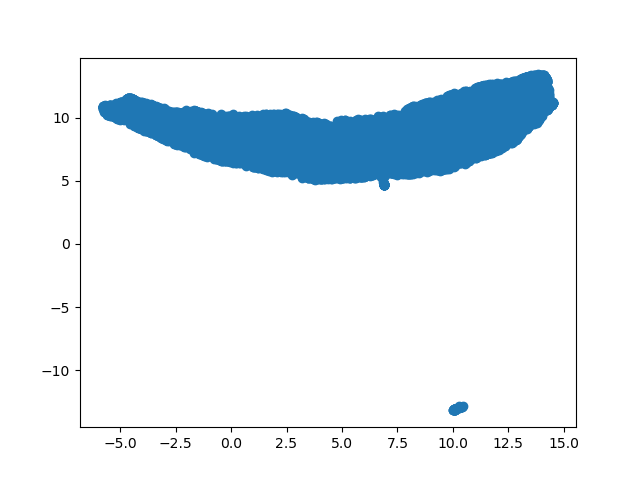

In [58]:
%matplotlib notebook
plt.scatter(embd[:, 0], embd[:, 1])

In [68]:
isolated_genes = np.where(embd[:, 1] < 0)[0]
isolated_names = expr_mat.iloc[isolated_genes, :].index.values
liftover.loc[liftover.accession.isin(isolated_names), :]

,chrom,type,start,end,attr,accession,desc
18894,scaffold_10,gene,813285,813521,ID=gene:ACA1_070310;biotype=protein_coding;des...,ACA1_070310,hypothetical protein
20216,scaffold_10,gene,1043662,1046264,ID=gene:ACA1_069420;biotype=protein_coding;des...,ACA1_069420,RhoGEF domain containing protein
43682,scaffold_14,gene,280896,281176,ID=gene:ACA1_377970;biotype=protein_coding;des...,ACA1_377970,hypothetical protein
45482,scaffold_14,gene,692534,694948,ID=gene:ACA1_110070;biotype=protein_coding;des...,ACA1_110070,"acetyltransferase, GNAT family"
57940,scaffold_16,gene,1169311,1170642,ID=gene:ACA1_254010;biotype=protein_coding;des...,ACA1_254010,hypothetical protein
59898,scaffold_17,gene,351656,352379,ID=gene:ACA1_224710;biotype=protein_coding;des...,ACA1_224710,universal stress domain containing protein
70934,scaffold_18,gene,1146599,1146811,ID=gene:ACA1_073840;biotype=protein_coding;des...,ACA1_073840,hypothetical protein
78522,scaffold_2,gene,5825,7171,ID=gene:ACA1_152400;biotype=protein_coding;des...,ACA1_152400,hypothetical protein
79580,scaffold_2,gene,223910,225189,ID=gene:ACA1_373940;biotype=protein_coding;des...,ACA1_373940,tetratricopeptide repeat domain containing pro...
101212,scaffold_21,gene,812315,813048,ID=gene:ACA1_275030;biotype=protein_coding;des...,ACA1_275030,hypothetical protein


<IPython.core.display.Javascript object>


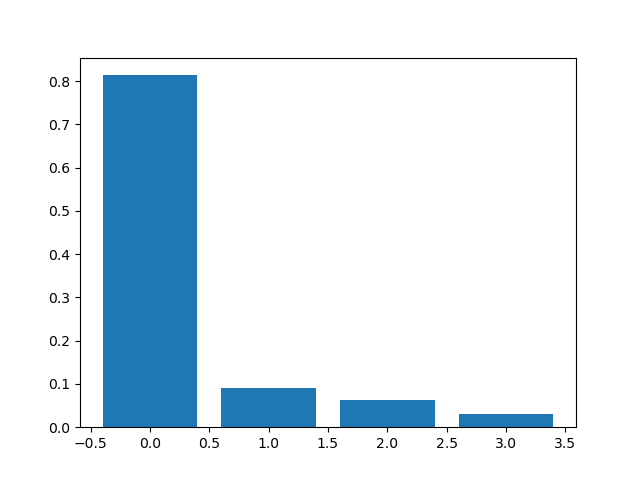

<BarContainer object of 4 artists>

In [137]:
%matplotlib notebook
plt.bar(range(pcs.shape[1]), pca.explained_variance_ratio_)

<IPython.core.display.Javascript object>


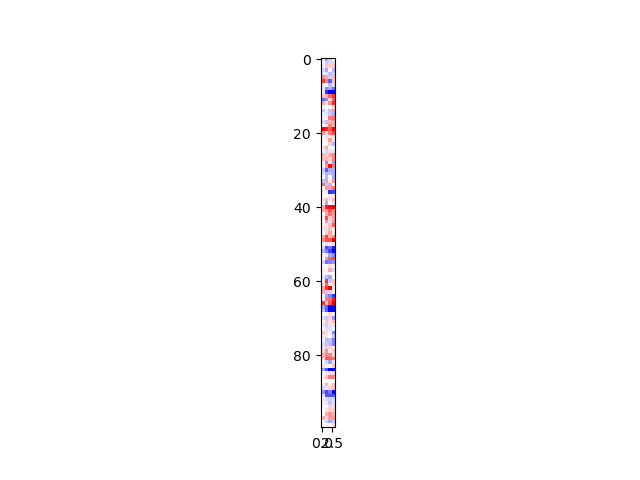

In [150]:
%matplotlib notebook
plt.imshow(expr_mat.to_numpy()[:100],cmap='bwr', vmin=-2, vmax=2)

<IPython.core.display.Javascript object>


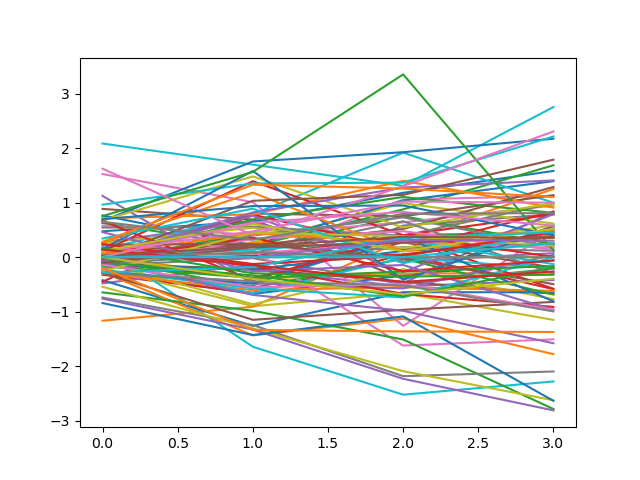

In [152]:
%matplotlib notebook
plt.plot(expr_mat.to_numpy()[:100].T)

#### Side note: Matrix around sirtuin gene sir6f

Below is an overview of the Hi-C contact map ratio of this gene's chromosome during infection.

In [31]:
import serpentine as serp
sir = sig_expr.loc[sig_expr.accession ==  'ACA1_153540', :]
sir_pos = clr_inf.extent(f'{sir.chrom.values[0]}:{int(sir.start.values[0])}-{int(sir.end.values[0])}')[0]
sir_pos -= clr_inf.extent(sir.chrom.values[0])[0]
sir_ctl = clr_ctl.matrix(balance=False).fetch(sir.chrom.values[0])
sir_inf = clr_inf.matrix(balance=False).fetch(sir.chrom.values[0])
sA, sB, sk = serp.serpentin_binning(sir_inf, sir_ctl, parallel=1, triangular=True)

2020-11-19 18:23:43.119351 Starting 10 binning processes...
0	 Total serpentines: 159895 (100.0 %)
1	 Total serpentines: 106470 (66.58744801275837 %)
2	 Total serpentines: 36715 (22.96194377560274 %)
3	 Total serpentines: 13272 (8.300447168454298 %)
4	 Total serpentines: 5607 (3.5066762562931926 %)
5	 Total serpentines: 3235 (2.0232027267894557 %)
6	 Total serpentines: 2528 (1.5810375558960568 %)
7	 Total serpentines: 2387 (1.4928546858876137 %)
8	 Total serpentines: 2373 (1.4840989399293287 %)
9	 Total serpentines: 2373 (1.4840989399293287 %)
9	 Over: 2020-11-19 18:23:46.677558
0	 Total serpentines: 159895 (100.0 %)
1	 Total serpentines: 106431 (66.56305700616029 %)
2	 Total serpentines: 36734 (22.973826573688985 %)
3	 Total serpentines: 13239 (8.27980862440977 %)
4	 Total serpentines: 5602 (3.5035492041652336 %)
5	 Total serpentines: 3200 (2.0013133618937426 %)
6	 Total serpentines: 2515 (1.5729072203633634 %)
7	 Total serpentines: 2364 (1.4784702460990025 %)
8	 Total serpentines: 23

<IPython.core.display.Javascript object>


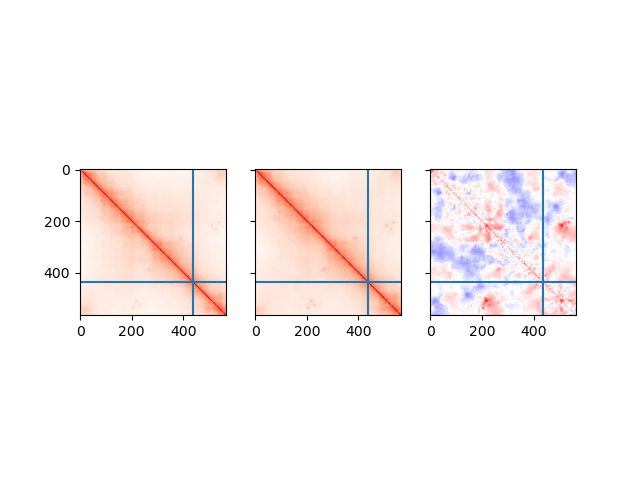

In [32]:
%matplotlib notebook
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
ax[0].imshow(np.log(sA), cmap='Reds')
ax[1].imshow(np.log(sB), cmap='Reds')
ax[2].imshow(sk, cmap='bwr')
for i in range(3):
    ax[i].axvline(sir_pos)
    ax[i].axhline(sir_pos)


Now, we will compare differential looping results from pareidolia with differential expression data.

In [34]:
loops_diff = pd.read_csv(
    'data/output/pareidolia/loops_change_infection_time.tsv',
    sep='\t',
)
loop24 = loops_diff.loc[loops_diff.chrom1 == 'scaffold_24', :]
start24 = clr_inf.extent('scaffold_24')[0]
loop24.bin1 -= start24
loop24.bin2 -= start24

<IPython.core.display.Javascript object>


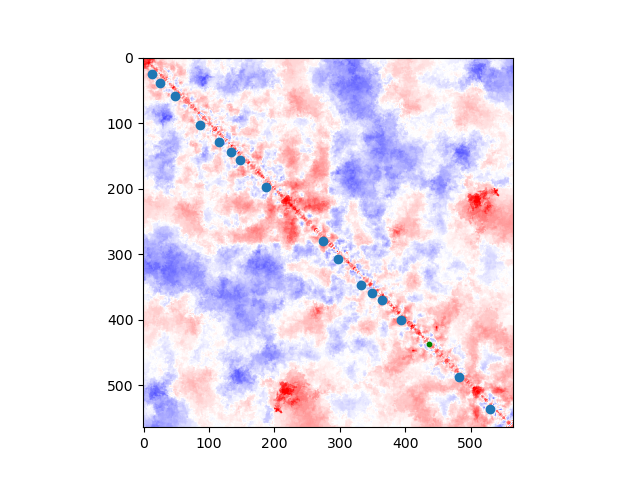

In [39]:
%matplotlib notebook
plt.imshow(sk - sk.mean(), cmap='bwr', vmin = -1, vmax=1)
plt.scatter(loop24.bin1, loop24.bin2)
s = clr_inf.extent('scaffold_24:875568-875568')[0] - start24
plt.scatter(s, s, s=10, c='green')